In [4]:
%load_ext autoreload
%autoreload 2

import json
from tqdm.auto import tqdm
from pathlib import Path
import plotting
import networkx as nx 
from joblib import Parallel, delayed
import contextlib
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from utils import make_graph
import pandas as pd
from copy import deepcopy
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import hashlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# https://stackoverflow.com/questions/24983493/tracking-progress-of-joblib-parallel-execution
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback:
        def __init__(self, time, index, parallel):
            self.index = index
            self.parallel = parallel

        def __call__(self, index):
            tqdm_object.update()
            if self.parallel._original_iterator is not None:
                self.parallel.dispatch_next()

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close() 

In [6]:
logs_path = Path('train_logs_single_run')
logs_paths = list(logs_path.glob("*.json"))

logs_ok = []
logs_not_ok = []
for idx, log_path in tqdm(enumerate(logs_paths), total=len(logs_paths)):
    with open(log_path, "r") as f:
        log = json.load(f)
    recepie = json.loads(log['recepie'])
    log['recepie'] = recepie
    log['idx'] = idx
    
    if log['status'] == 'OK':
        logs_ok.append(log)
    else:
        logs_not_ok.append(log)

In [7]:
print("number ok: ", len(logs_ok))
print("number not ok: ", len(logs_not_ok))

number ok:  11598
number not ok:  2724


In [8]:
len(logs_not_ok)/len(logs_ok)

0.23486808070356957

In [9]:
def map_node(x):
    for v in ['node', 'h_prev', 'h_new']:
        if x.find(v) != -1:
            x = v
    if x not in ['x', 'node', 'h_prev', 'h_new']: # to make lstm and gru recepies standard
        x = 'node'
    return x

In [10]:
def make_graph_2(recepie):
    
    G = nx.DiGraph()
    for n in recepie.keys():
        if n not in G.nodes():
            G.add_node(n)
        for k in recepie[n]['input']:
            if k not in G.nodes():
                G.add_node(k)
            G.add_edge(n, k, label=recepie[n]['op'])
            G.add_edge(k, n, label='rev_' + recepie[n]['op'])
    return G

In [11]:
def random_walk_features(G, steps=10):
    walk = []
    node = np.random.choice(G.nodes(), 1)[0]
    for _ in range(steps):
        k = np.random.choice(list(G.adj[node]), 1)[0]
        walk.extend([map_node(node), G.adj[node][k]['label']])
        node = k
    walk.append(map_node(node))
    return walk

In [12]:
def make_graph_sentences(G, sentences_num=20):
    sentences = []
    for _ in range(sentences_num):
        sentences.extend(random_walk_features(G) + ['.'])
    return sentences

In [13]:
def feature_extractor(log):
    name = f"log_{log['idx']}"
    recepie = log['recepie']
    G = make_graph_2(recepie)
    doc = TaggedDocument(words=make_graph_sentences(G), tags=[name])
    return doc

In [14]:
document_collections = Parallel(n_jobs=-2)(delayed(feature_extractor)(log) for log in tqdm(logs_not_ok+logs_ok))

In [15]:
# takes a while!!
size = 10
# size = 50
doc2vec_model = Doc2Vec(document_collections, 
                        size=size, window=3, dm=1, min_count=0, workers=8, epochs=100, hs=1,
                        dbow_words=0)

/userhome/34/ecysit/anaconda3/envs/NASNLP/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [16]:
all_words = set()
for d in document_collections:
    all_words |= set(d.words)
len(all_words)

19

In [17]:
not_dublicates_ok_logs = []
not_dublicates_not_ok_logs = []
not_dublicates_recepies = []
for log in logs_not_ok+logs_ok:
    recepie = log['recepie']
    if recepie not in not_dublicates_recepies:
        not_dublicates_recepies.append(recepie)
        if log['status'] == 'OK':
            not_dublicates_ok_logs.append(log)
        else:
            not_dublicates_not_ok_logs.append(log)
print("total: ", len(logs_not_ok+logs_ok))
print("without dublicates: ", len(not_dublicates_ok_logs+not_dublicates_not_ok_logs))

total:  14322
without dublicates:  14322


In [18]:
#dump vectors
recepie_id_vectors = {log['recepie_id']:doc2vec_model.docvecs[f"log_{log['idx']}"]
                      for log in not_dublicates_ok_logs+not_dublicates_not_ok_logs}


In [19]:
recepie_id_vectors_list = []
for k in recepie_id_vectors:
    k_dict = {'recepie_id':k}
    for i in range(doc2vec_model.vector_size):
        k_dict[f'v{i:02d}'] = recepie_id_vectors[k][i]
    recepie_id_vectors_list.append(k_dict)

In [20]:
df_recepie_vectors = pd.DataFrame(recepie_id_vectors_list)

In [21]:
df_recepie_vectors.head()

,recepie_id,v00,v01,v02,v03,v04,v05,v06,v07,v08,v09
0,1007422,-3.490780,0.860867,3.358218,-1.715680,-3.695592,6.945653,1.237087,3.511198,1.576271,1.777857
1,2009264,2.364941,-1.622708,2.076709,0.074054,0.708793,1.103378,2.728885,-1.206563,2.826059,-3.755569
2,1010304,0.246651,4.045632,2.333278,-1.231062,-2.903378,2.796354,1.423086,0.632260,2.484250,-0.237902
3,2007703,-1.027656,-0.515293,-0.828772,0.805497,-1.107228,-1.996114,1.973436,-1.540095,4.991573,1.501001
4,2003253,1.013229,0.433450,1.908064,-2.494451,-2.008942,3.368364,1.228186,0.811133,2.847766,0.701892


In [22]:
# if size == 50:
#     df_recepie_vectors.to_csv('data/doc2vec_features.csv', index=False)
# elif size == 10:
#     df_recepie_vectors.to_csv('data/doc2vec_features_lowdim.csv', index=False)

In [23]:
df_recepie_vectors = pd.read_csv('data/doc2vec_features.csv').set_index('recepie_id')

In [24]:
trainset_list = [
    (df_recepie_vectors.loc[log['recepie_id']], int(log['status'] == 'OK'))
    for log in not_dublicates_ok_logs+not_dublicates_not_ok_logs
]

random.shuffle(trainset_list)

trainset_np, testset_np = np.array(trainset_list[:7000]), np.array(trainset_list[7000:])
train_X, train_y = np.array(list(trainset_np[:, 0])), np.array(list(trainset_np[:, 1]))
test_X, test_y = np.array(list(testset_np[:, 0])), np.array(list(testset_np[:, 1]))

print("Train:", len(trainset_np))
print("Test: ", len(testset_np))

num_train_not_ok = len(train_y) - train_y.sum()
print("\nTrain OK: ", train_y.sum())
print("Train not OK: ", num_train_not_ok)

num_test_not_ok = len(test_y) - test_y.sum()
print("\nTest OK: ", test_y.sum())
print("Test not OK: ", num_test_not_ok)

Train: 7000
Test:  7322

Train OK:  5657
Train not OK:  1343

Test OK:  5941
Test not OK:  1381


In [25]:
tsne = TSNE(n_components=2, n_iter=300, verbose=True)

In [26]:
E = tsne.fit_transform(train_X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.043s...
[t-SNE] Computed neighbors for 7000 samples in 5.414s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 1.461245
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.929077
[t-SNE] KL divergence after 300 iterations: 2.236224


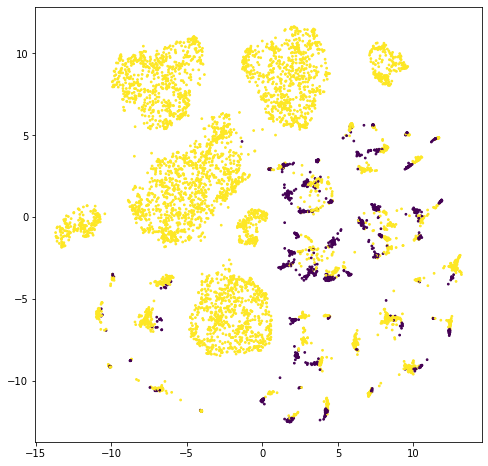

In [27]:
plt.figure(figsize=(8, 8))
plt.scatter(E[:, 0], E[:, 1], s=3, c=train_y)

In [30]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc 

In [31]:
model = XGBClassifier(n_jobs=-1)
model.fit(train_X, train_y)

pred_y = model.predict_proba(test_X)
precision_xgboost, recall_xgboost, _ = precision_recall_curve(test_y, pred_y[:, 1])
fpr_xgboost, tpr_xgboost, _ = roc_curve(test_y, pred_y[:, 1])
roc_auc_axboost = auc(fpr_xgboost, tpr_xgboost)

f1_test_score = f1_score(test_y, np.argmax(pred_y, 1))
ap_test_score = average_precision_score(test_y, pred_y[:, 1])
print("XGBoost F1 score: ", f1_test_score)
print("XGBoost Average Precision score: ", ap_test_score)

XGBoost F1 score:  0.9902439024390245
XGBoost Average Precision score:  0.9995872083142645


In [32]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(train_X, train_y)
pred_y = clf.predict_proba(test_X)
precision_lr, recall_lr, _ = precision_recall_curve(test_y, pred_y[:,1])
fpr_lr, tpr_lr, _ = roc_curve(test_y, pred_y[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

f1_test_score = f1_score(test_y, np.argmax(pred_y, 1))
ap_test_score = average_precision_score(test_y, pred_y[:, 1])
print("Logistic Regression F1 score: ", f1_test_score)
print("CatBoost Average Precision score: ", ap_test_score)

Logistic Regression F1 score:  0.9672267509565795
CatBoost Average Precision score:  0.9938435151827535


/userhome/34/ecysit/anaconda3/envs/NASNLP/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


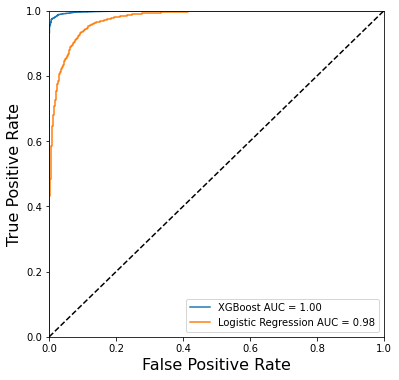

In [33]:
#plt.title('Receiver Operating Characteristic')
plt.figure(figsize=(6, 6))
plt.plot(fpr_xgboost, tpr_xgboost, label='XGBoost AUC = %0.2f' % roc_auc_axboost)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression AUC = %0.2f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)

plt.savefig('data/figures/prediction_faulty.png', dpi=300, bbox_inches='tight')

In [34]:
trainset_list = [
    (doc2vec_model.docvecs[f"log_{log['idx']}"], np.array(log['val_losses']).min())
    for log in not_dublicates_ok_logs
]


np.random.seed(0)
random.shuffle(trainset_list)

trainset_np, testset_np = np.array(trainset_list[:7000]), np.array(trainset_list[7000:])
train_X, train_y = np.array(list(trainset_np[:, 0])), np.array(list(trainset_np[:, 1]))
test_X, test_y = np.array(list(testset_np[:, 0])), np.array(list(testset_np[:, 1]))

print("Train:", len(trainset_np))
print("Test: ", len(testset_np))

num_train_not_ok = len(train_y) - train_y.sum()
print("\nTrain OK: ", train_y.sum())
print("Train not OK: ", num_train_not_ok)

num_test_not_ok = len(test_y) - test_y.sum()
print("\nTest OK: ", test_y.sum())
print("Test not OK: ", num_test_not_ok)

Train: 7000
Test:  4598

Train OK:  36067.596603217695
Train not OK:  -29067.596603217695

Test OK:  23778.827104078387
Test not OK:  -19180.827104078387


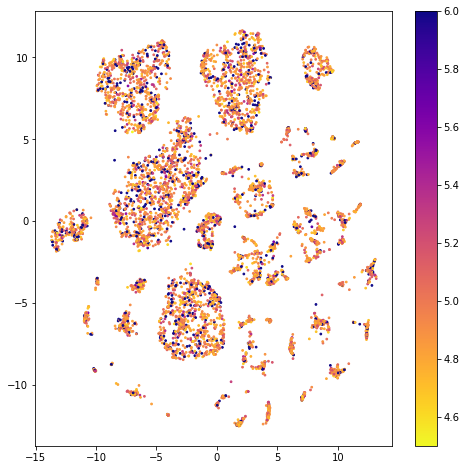

In [35]:
plt.figure(figsize=(8, 8))
plt.scatter(E[:, 0], E[:, 1], s=3, c=train_y, cmap=plt.cm.plasma_r)
plt.colorbar()
plt.clim([4.5, 6])

In [36]:
train_y

array([6.51920882, 4.80889797, 5.09001589, ..., 4.94033336, 4.81422669,
       4.90242419])

In [37]:
(train_y > 6).mean()

0.14342857142857143

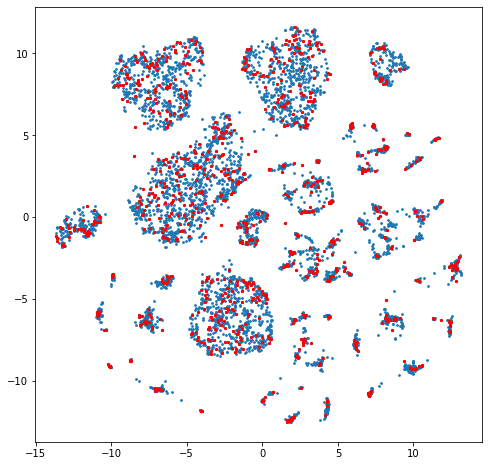

In [38]:
plt.figure(figsize=(8, 8))
plt.scatter(E[:, 0], E[:, 1], s=3, color='C0')
sub_inds = np.where(train_y > 6)[0]
plt.scatter(E[sub_inds, 0], E[sub_inds, 1], s=5, color='red')

In [39]:
model = XGBClassifier(n_jobs=-1)
model.fit(train_X, train_y > 6)

pred_y = model.predict_proba(test_X)
precision_xgboost, recall_xgboost, _ = precision_recall_curve(test_y > 6, pred_y[:, 1])
fpr_xgboost, tpr_xgboost, _ = roc_curve(test_y > 6, pred_y[:, 1])
roc_auc_axboost = auc(fpr_xgboost, tpr_xgboost)

f1_test_score = f1_score(test_y > 6, np.argmax(pred_y, 1))
ap_test_score = average_precision_score(test_y > 6, pred_y[:, 1])
print("XGBoost F1 score: ", f1_test_score)
print("XGBoost Average Precision score: ", ap_test_score)

XGBoost F1 score:  0.23169398907103825
XGBoost Average Precision score:  0.3342091255680413


Text(0.5, 0, 'False Positive Rate')

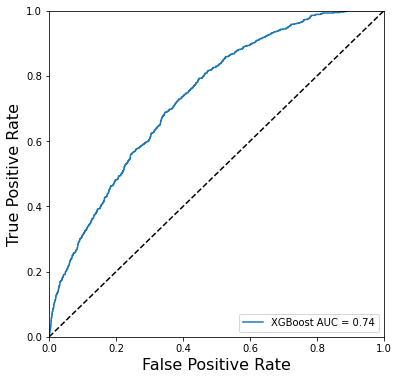

In [40]:
#plt.title('Receiver Operating Characteristic')
plt.figure(figsize=(6, 6))
plt.plot(fpr_xgboost, tpr_xgboost, label='XGBoost AUC = %0.2f' % roc_auc_axboost)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)


In [41]:
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score

regr = BaggingRegressor(XGBRegressor(n_estimators=100, max_depth=15), n_jobs=10, n_estimators=20, max_samples=0.5).fit(train_X, train_y)
regr_6 = BaggingRegressor(XGBRegressor(n_estimators=100, max_depth=15), n_jobs=10, n_estimators=20, max_samples=0.5).fit(train_X[train_y < 6], train_y[train_y < 6])
pred_y = regr.predict(test_X)
pred_y_6 = regr_6.predict(test_X)


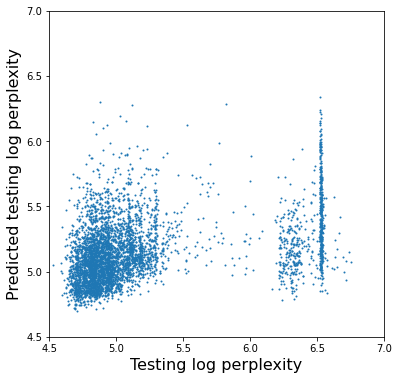

In [42]:
plt.figure(figsize=(6, 6))
plt.scatter(test_y, pred_y, s=1)
plt.xlabel('Testing log perplexity', fontsize=16)
plt.ylabel('Predicted testing log perplexity', fontsize=16)
plt.xlim([4.5, 7])
plt.ylim([4.5, 7])
plt.savefig('data/figures/prediction_loss.png', dpi=300, bbox_inches='tight')

In [43]:
r2_score(test_y, pred_y)

0.14839221428463623

In [44]:
r2_score(test_y, pred_y_6)

-0.12477919368375634

In [45]:
r2_score(test_y[test_y < 6], pred_y[test_y < 6])

-1.335770037456756

In [46]:
r2_score(test_y[test_y < 6], pred_y_6[test_y < 6])

0.24689453622985824